# Predictive Classification Models

In [1]:
import pandas as pd
import matplotlib
import seaborn as sns
import numpy as np
import sklearn
import imblearn
import matplotlib.pyplot as plt

In [2]:
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, PowerTransformer
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_classif
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import cross_validate
from sklearn.metrics import RocCurveDisplay
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

In [3]:
data = "../data/ml_project_data_clust.csv"

dfi_clust = pd.read_csv(data)

dfi_clust.head()

,Education,Marital_Status,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,...,Age,AgeGroup,MntTotal,MntRegProds,NbChildren,ChildrenPresence,AcceptedCmpTotal,AcceptedSomeCmp,NumTotalPurchases,Cluster
0,Graduation,Single,58138.0,0,0,58,635,88,546,172,...,57,45-64,1617,1529,0,0,0,0,22,1
1,Graduation,Single,46344.0,1,1,38,11,1,6,2,...,60,45-64,27,21,2,1,0,0,4,0
2,Graduation,HasPartner,71613.0,0,0,26,426,49,127,111,...,49,45-64,776,734,0,0,0,0,20,1
3,Graduation,HasPartner,26646.0,1,0,26,11,4,20,10,...,30,26-44,53,48,1,1,0,0,6,0
4,PhD,HasPartner,58293.0,1,0,94,173,43,118,46,...,33,26-44,422,407,1,1,0,0,14,2


In [4]:
dfi_clust.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2205 entries, 0 to 2204
Data columns (total 36 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Education            2205 non-null   object 
 1   Marital_Status       2205 non-null   object 
 2   Income               2205 non-null   float64
 3   Kidhome              2205 non-null   int64  
 4   Teenhome             2205 non-null   int64  
 5   Recency              2205 non-null   int64  
 6   MntWines             2205 non-null   int64  
 7   MntFruits            2205 non-null   int64  
 8   MntMeatProducts      2205 non-null   int64  
 9   MntFishProducts      2205 non-null   int64  
 10  MntSweetProducts     2205 non-null   int64  
 11  MntGoldProds         2205 non-null   int64  
 12  NumDealsPurchases    2205 non-null   int64  
 13  NumWebPurchases      2205 non-null   int64  
 14  NumCatalogPurchases  2205 non-null   int64  
 15  NumStorePurchases    2205 non-null   i

## Data Preparation

- `Response` is the target to be reached out

In [5]:
# Separating features and target variable from the dataset
X = dfi_clust.drop("Response", axis=1)
y = dfi_clust["Response"]

In [6]:
X.head()

,Education,Marital_Status,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,...,Age,AgeGroup,MntTotal,MntRegProds,NbChildren,ChildrenPresence,AcceptedCmpTotal,AcceptedSomeCmp,NumTotalPurchases,Cluster
0,Graduation,Single,58138.0,0,0,58,635,88,546,172,...,57,45-64,1617,1529,0,0,0,0,22,1
1,Graduation,Single,46344.0,1,1,38,11,1,6,2,...,60,45-64,27,21,2,1,0,0,4,0
2,Graduation,HasPartner,71613.0,0,0,26,426,49,127,111,...,49,45-64,776,734,0,0,0,0,20,1
3,Graduation,HasPartner,26646.0,1,0,26,11,4,20,10,...,30,26-44,53,48,1,1,0,0,6,0
4,PhD,HasPartner,58293.0,1,0,94,173,43,118,46,...,33,26-44,422,407,1,1,0,0,14,2


### Data Transformation

The preprocessing built in Clustering part will be replicated here.

In [7]:
onehotenc_cols = [
    "Education",
    "Marital_Status",
    "AgeGroup",
    "ChildrenPresence",
    "AcceptedSomeCmp",
    "AcceptedCmp1",
    "AcceptedCmp2",
    "AcceptedCmp3",
    "AcceptedCmp4",
    "AcceptedCmp5",
    "Complain",
    "Kidhome",
    "Teenhome",
    "YearsEnrolled",
    "NbChildren",
    "AcceptedCmpTotal",
    "Cluster"
]

standardsc_cols = [
    "Income",
    "Age"
]

powertrans_cols = X.columns[
    X.columns.str.startswith("Mnt") | X.columns.str.startswith("Num")
].tolist()

minmaxsc_cols = [
    col for col in X.columns if col not in onehotenc_cols + standardsc_cols + powertrans_cols
]

## Modelling

### Dataset Split

In [8]:
# Splitting the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

### Define Models and Cross-Validation Strategy

- Models and cross-validation strategy are defined before creating the pipeline to ensure the pipeline function has all the necessary inputs.

Three models will be compared:
1. **Decision Tree**: Simple and easy to understand.
2. **Logistic Regression**: Linear model, good for interpretability.
3. **K-Nearest Neighbors (KNN)**: Simple and effective for certain types of data.

Also the `DummyClassifier` will be used as a baseline to compare the models against.
- The DummyClassifier in scikit-learn is a baseline model used for comparison purposes. Its main role is to provide a benchmark against which more complex models can be compared. It doesn't use any actual learning algorithm; instead, it makes predictions based on simple rules. 

In [9]:
Random_State = 42

# Define the models
models = {
    "DummyClassifier": DummyClassifier(strategy="stratified", random_state=Random_State),
    "DecisionTree": DecisionTreeClassifier(random_state=Random_State),
    "LogisticRegression": LogisticRegression(random_state=Random_State),
    "KNN": KNeighborsClassifier(n_neighbors=5)
}


In [10]:
# Define Stratified K-Fold cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=Random_State)

- Stratified K-Fold ensures that each fold of the dataset has the same proportion of class labels, which is important for classification tasks.

### Model Building

#### Define Pipeline Model Function

In [11]:
# Function to create and evaluate a pipeline model
def evaluate_pipeline_model(X, y, model, kf):
    # Define the preprocessing steps
    preprocessing = ColumnTransformer(
        [
            ("onehot", OneHotEncoder(), onehotenc_cols),
            ("standardsc", StandardScaler(), standardsc_cols),
            ("powertrans", PowerTransformer(), powertrans_cols),
            ("minmaxsc", MinMaxScaler(), minmaxsc_cols)
        ]
    )

    # Create the pipeline
    pipeline = Pipeline(
        [
            ("preprocessing", preprocessing),
            ("feature_selection", SelectKBest(score_func=f_classif, k=10)),
            ("rus", RandomUnderSampler(random_state=Random_State)),
            ("model", model)
        ]
    )

    # Perform cross-validation
    scores = cross_validate(
        pipeline,
        X,
        y,
        cv=kf,
        scoring=["accuracy", "precision", "recall", "roc_auc", "average_precision"],
        n_jobs=-1
    )

    return scores

- This function builds a machine learning pipeline, performs cross-validation, and returns the evaluation scores.

## Evaluation

### Model Assessment

In [12]:
# Evaluate models and store results
results = {
    model_name: evaluate_pipeline_model(X_train, y_train, model, skf)
    for model_name, model in models.items()
}

# Add "time" column with the sum of fit and score times
for model_name, score in results.items():
    score["time"] = score["fit_time"] + score["score_time"]

from pprint import pprint

pprint(results)

{'DecisionTree': {'fit_time': array([0.07931423, 0.08583045, 0.08935118, 0.08935118, 0.09278774]),
                  'score_time': array([0.03717613, 0.03717613, 0.03352618, 0.03352618, 0.04106927]),
                  'test_accuracy': array([0.83569405, 0.84985836, 0.81869688, 0.84135977, 0.79545455]),
                  'test_average_precision': array([0.36071451, 0.39568063, 0.34003417, 0.40418212, 0.39862568]),
                  'test_precision': array([0.45614035, 0.5       , 0.40677966, 0.484375  , 0.38271605]),
                  'test_recall': array([0.49056604, 0.54716981, 0.45283019, 0.57407407, 0.58490566]),
                  'test_roc_auc': array([0.67915094, 0.72968553, 0.66654088, 0.74863743, 0.73840475]),
                  'time': array([0.11649036, 0.12300658, 0.12287736, 0.12287736, 0.13385701])},
 'DummyClassifier': {'fit_time': array([0.09121966, 0.07805443, 0.0805881 , 0.10829759, 0.07110238]),
                     'score_time': array([0.02036691, 0.0232985 , 0.0308454

### Interpret Results

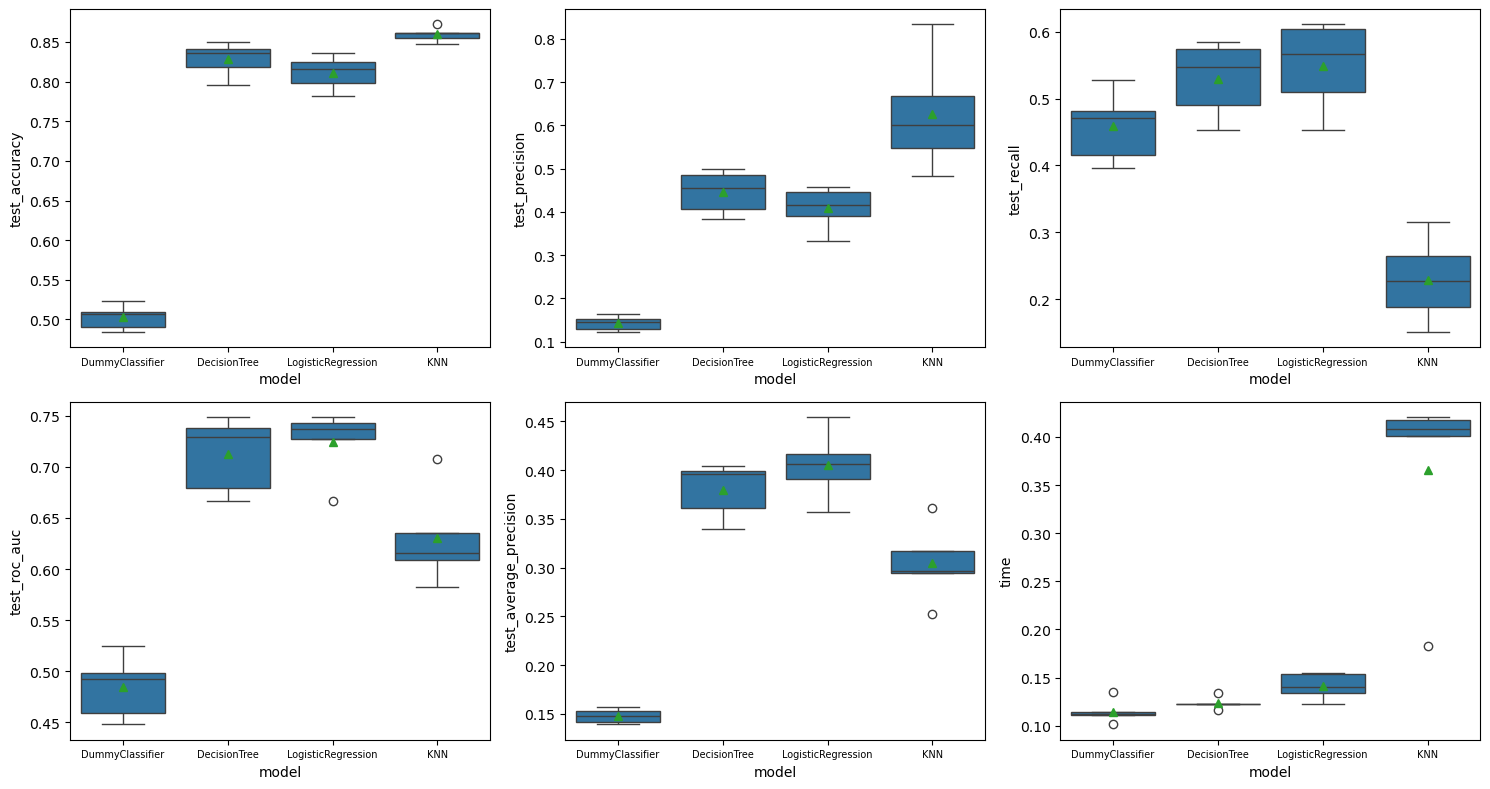

In [13]:
# Convert results to DataFrame for visualization
dfi_results = pd.DataFrame(results).T.reset_index().rename(columns={"index": "model"})

# Explode the DataFrame to make each score a separate row
dfi_results_explode = dfi_results.explode(dfi_results.columns[1:].to_list()).reset_index(drop=True)

# Plot boxplots for each metric
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(15, 8), tight_layout=True)

# Columns to plot
metrics = ["test_accuracy", "test_precision", "test_recall", "test_roc_auc", "test_average_precision", "time"]

# Create boxplots for each metric
for ax, metric in zip(axs.flatten(), metrics):
    sns.boxplot(x="model", y=metric, data=dfi_results_explode, ax=ax, showmeans=True)
    ax.tick_params(axis='x', labelsize=7)

# Display the plots
plt.show()

**Summary**
- Cross-validation ensures robust model evaluation by dividing the data into multiple folds and providing multiple performance scores.
- Results Structure: The dictionary returned by cross_validate contains arrays of scores for each fold, which helps in understanding model performance across different subsets of data.
- Visualizations: Boxplots help in comparing the performance of different models visually, highlighting variations and central tendencies in their performance.
    - The six boxplots in the figure illustrate the performance of four different classification models (DummyClassifier, DecisionTree, LogisticRegression, and KNN) across six metrics: accuracy, precision, recall, ROC AUC, average precision, and time. Each boxplot shows the distribution of scores obtained from 5-fold cross-validation.
    - Despite KNN having slightly higher accuracy and precision, LogisticRegression provides the best balance of all metrics, including recall, ROC AUC, and average precision, which are crucial for imbalanced datasets. It also has reasonable computational efficiency, leading to its selection for further optimization.


#### Selection of LogisticRegression
- Balanced Performance: LogisticRegression performs well across multiple metrics: accuracy, precision, recall, ROC AUC, and average precision.
- Highest Recall: LogisticRegression has the highest recall, which is crucial for capturing true positives in an imbalanced dataset.
- ROC AUC and Average Precision: For imbalanced datasets, these metrics are particularly important. LogisticRegression has the highest scores in these areas, making it the most reliable model for this dataset.
- Time Efficiency: LogisticRegression has a reasonable fit and score time compared to KNN, which is the slowest.


# Logistic Regression - Hyperparameters Optimization

### Initial Setup and Model Reproduction

First, it will be reproduced the logistic regression model without hyperparameter optimization

In [14]:
# Define preprocessing steps
preprocessing = ColumnTransformer(
    [
        ("onehot", OneHotEncoder(), onehotenc_cols),
        ("standardsc", StandardScaler(), standardsc_cols),
        ("powertrans", PowerTransformer(), powertrans_cols),
        ("minmaxsc", MinMaxScaler(), minmaxsc_cols)
    ]
)

# Split the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=Random_State)

# Define the pipeline with preprocessing, feature selection, undersampling, and logistic regression
pipeline_logreg = Pipeline(
    [
        ("preprocessing", preprocessing),
        ("feature_selection", SelectKBest(score_func=f_classif, k=10)),
        ("rus", RandomUnderSampler(random_state=Random_State)),
        ("model", LogisticRegression(random_state=Random_State))
    ]
)

# Fit the pipeline on the training set
pipeline_logreg.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('onehot', OneHotEncoder(),
                                                  ['Education',
                                                   'Marital_Status', 'AgeGroup',
                                                   'ChildrenPresence',
                                                   'AcceptedSomeCmp',
                                                   'AcceptedCmp1',
                                                   'AcceptedCmp2',
                                                   'AcceptedCmp3',
                                                   'AcceptedCmp4',
                                                   'AcceptedCmp5', 'Complain',
                                                   'Kidhome', 'Teenhome',
                                                   'YearsEnrolled',
                                                   'NbChildren',
                                                   'AcceptedCmpTotal',
                                                   'Cluster']),
                                                 ('standardsc',...
                                                   'MntSweetProducts',
                                                   'MntGoldProds',
                                                   'NumDealsPurchases',
                                                   'NumWebPurchases',
                                                   'NumCatalogPurchases',
                                                   'NumStorePurchases',
                                                   'NumWebVisitsMonth',
                                                   'MntTotal', 'MntRegProds',
                                                   'NumTotalPurchases']),
                                                 ('minmaxsc', MinMaxScaler(),
                                                  ['Recency',
                                                   'DaysEnrolled'])])),
                ('feature_selection', SelectKBest()),
                ('rus', RandomUnderSampler(random_state=42)),
                ('model', LogisticRegression(random_state=42))])

In [15]:
# Get and print the names of the preprocessed features
feature_names_prep = pipeline_logreg.named_steps["preprocessing"].get_feature_names_out()
print("Feature names:", feature_names_prep)
print("Number of features:", len(feature_names_prep))

# Get and print the names of the selected features
feature_names_selec = pipeline_logreg.named_steps["feature_selection"].get_feature_names_out(feature_names_prep)
print("Selected feature names:", feature_names_selec)
print("Number of selected features:", len(feature_names_selec))

Feature names: ['onehot__Education_2n Cycle' 'onehot__Education_Basic'
 'onehot__Education_Graduation' 'onehot__Education_Master'
 'onehot__Education_PhD' 'onehot__Marital_Status_HasPartner'
 'onehot__Marital_Status_Single' 'onehot__AgeGroup_18-25'
 'onehot__AgeGroup_26-44' 'onehot__AgeGroup_45-64' 'onehot__AgeGroup_65+'
 'onehot__ChildrenPresence_0' 'onehot__ChildrenPresence_1'
 'onehot__AcceptedSomeCmp_0' 'onehot__AcceptedSomeCmp_1'
 'onehot__AcceptedCmp1_0' 'onehot__AcceptedCmp1_1'
 'onehot__AcceptedCmp2_0' 'onehot__AcceptedCmp2_1'
 'onehot__AcceptedCmp3_0' 'onehot__AcceptedCmp3_1'
 'onehot__AcceptedCmp4_0' 'onehot__AcceptedCmp4_1'
 'onehot__AcceptedCmp5_0' 'onehot__AcceptedCmp5_1' 'onehot__Complain_0'
 'onehot__Complain_1' 'onehot__Kidhome_0' 'onehot__Kidhome_1'
 'onehot__Kidhome_2' 'onehot__Teenhome_0' 'onehot__Teenhome_1'
 'onehot__Teenhome_2' 'onehot__YearsEnrolled_0' 'onehot__YearsEnrolled_1'
 'onehot__NbChildren_0' 'onehot__NbChildren_1' 'onehot__NbChildren_2'
 'onehot__NbChil

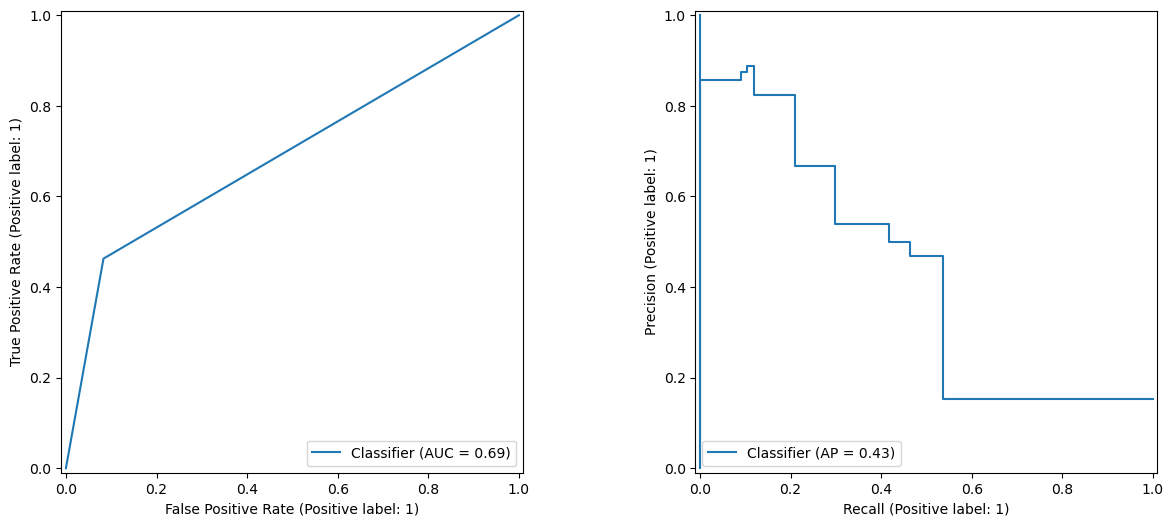

In [16]:
# Evaluate on the test set
y_test_pred = pipeline_logreg.predict(X_test)
y_test_pred_proba = pipeline_logreg.decision_function(X_test)

fig, axs = plt.subplots(1, 2, figsize=(15, 6))

# Plot ROC curve using test set predictions
roc_test = RocCurveDisplay.from_predictions(y_test, y_test_pred, ax=axs[0])

# Plot Precision-Recall curve using test set predictions
prc_test = PrecisionRecallDisplay.from_predictions(y_test, y_test_pred_proba, ax=axs[1])

plt.show()

- ROC Curve: The ROC curve plots the True Positive Rate (TPR) against the False Positive Rate (FPR) and has an Area Under the Curve (AUC) of 0.69, indicating a moderate ability of the classifier to distinguish between positive and negative classes. This suggests the classifier performs better than random guessing but still has significant room for improvement.
- Precision-Recall Curve: The Precision-Recall curve, which plots precision against recall, shows an Average Precision (AP) of 0.43. This indicates a moderate trade-off between precision and recall, suggesting that the classifier’s predictions are reasonably accurate, but there is still a substantial number of false positives and false negatives that could be reduced with further model optimization.

## Modelling

### Hyperparameter Optimization with GridSearchCV

The hyperparameters of the Logistic Regression model will be optimized using GridSearchCV. 
- GridSearchCV performs an exhaustive search over a specified parameter grid, utilizing cross-validation to identify the best combination of hyperparameters for the estimator. This process ensures the model is fine-tuned for optimal performance based on the provided data.

In [17]:
import warnings

warnings.filterwarnings("ignore")

In [18]:
# Define the parameter grid for GridSearchCV
param_grid = {
    "feature_selection__k": [10, 15, 20, 25, 30],
    "model__C": np.logspace(-3, 3, 7),
    "model__solver": ["liblinear", "lbfgs", "saga"],
    "model__penalty": ["l1", "l2", "elasticnet", "none"]
}

# Instantiate GridSearchCV
grid_search = GridSearchCV(
    pipeline_logreg,
    param_grid,
    scoring=["roc_auc", "average_precision", "accuracy"],
    n_jobs=-1,
    refit="average_precision" # Refit the model using the best parameter setting for average precision
)

# Fit GridSearchCV on the training set
grid_search.fit(X_train, y_train) 

GridSearchCV(estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('onehot',
                                                                         OneHotEncoder(),
                                                                         ['Education',
                                                                          'Marital_Status',
                                                                          'AgeGroup',
                                                                          'ChildrenPresence',
                                                                          'AcceptedSomeCmp',
                                                                          'AcceptedCmp1',
                                                                          'AcceptedCmp2',
                                                                          'AcceptedCmp3',
                                                                          'AcceptedCmp4',
                                                                          'AcceptedCmp5',
                                                                          'Complain',
                                                                          'Kidhome',
                                                                          'Teenhome',
                                                                          'YearsEnrolled',
                                                                          'NbChildren',
                                                                          'AcceptedCmpTotal',
                                                                          'Cl...
                                       ('model',
                                        LogisticRegression(random_state=42))]),
             n_jobs=-1,
             param_grid={'feature_selection__k': [10, 15, 20, 25, 30],
                         'model__C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'model__penalty': ['l1', 'l2', 'elasticnet', 'none'],
                         'model__solver': ['liblinear', 'lbfgs', 'saga']},
             refit='average_precision',
             scoring=['roc_auc', 'average_precision', 'accuracy'])

- GridSearchCV is applied only to the training set, not the entire dataset. This approach ensures that the model is tuned without any data leakage from the test set, which would otherwise lead to overly optimistic performance estimates and a model that might not generalize well to new data.

In [19]:
# Print the best parameters and estimator
print("Best parameters found:", grid_search.best_params_)
print("Best estimator found:", grid_search.best_estimator_)

Best parameters found: {'feature_selection__k': 25, 'model__C': 1000.0, 'model__penalty': 'l1', 'model__solver': 'liblinear'}
Best estimator found: Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('onehot', OneHotEncoder(),
                                                  ['Education',
                                                   'Marital_Status', 'AgeGroup',
                                                   'ChildrenPresence',
                                                   'AcceptedSomeCmp',
                                                   'AcceptedCmp1',
                                                   'AcceptedCmp2',
                                                   'AcceptedCmp3',
                                                   'AcceptedCmp4',
                                                   'AcceptedCmp5', 'Complain',
                                                   'Kidhome', 'Teenhome',
                                  

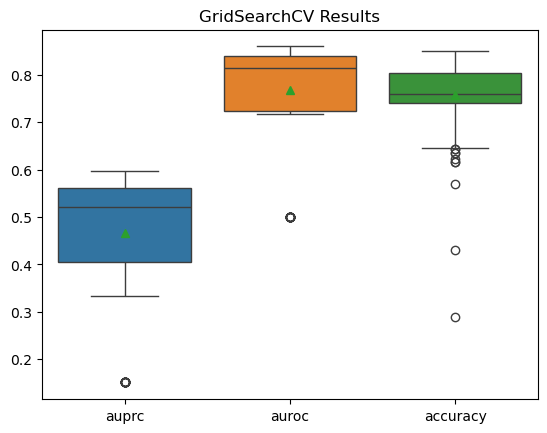

In [20]:
# Create DataFrame of the GridSearchCV results
dfi_results_gs = pd.DataFrame(
    {
        "auprc": grid_search.cv_results_["mean_test_average_precision"],
        "auroc": grid_search.cv_results_["mean_test_roc_auc"],
        "accuracy": grid_search.cv_results_["mean_test_accuracy"],
    }
)

# Plot the GridSearchCV results
sns.boxplot(data=dfi_results_gs, showmeans=True)
plt.title("GridSearchCV Results")
plt.show()

### Retrain the Model with Optimized Parameters
- Using the best parameters from GridSearchCV to create and evaluate a new pipeline. This ensures that the model is optimized for the given dataset.

In [21]:
# Create pipeline with best parameters
pipeline_logreg_best = Pipeline(
    [
        ("preprocessing", preprocessing),
        ("feature_selection", SelectKBest(score_func=f_classif, k=grid_search.best_params_["feature_selection__k"])),
        ("rus", RandomUnderSampler(random_state=Random_State)),
        ("model", LogisticRegression(
            random_state=Random_State,
            C=grid_search.best_params_["model__C"],
            penalty=grid_search.best_params_["model__penalty"],
            solver=grid_search.best_params_["model__solver"]
        ))
    ]
)

# Fit the model on the training set
pipeline_logreg_best.fit(X_train, y_train)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('onehot', OneHotEncoder(),
                                                  ['Education',
                                                   'Marital_Status', 'AgeGroup',
                                                   'ChildrenPresence',
                                                   'AcceptedSomeCmp',
                                                   'AcceptedCmp1',
                                                   'AcceptedCmp2',
                                                   'AcceptedCmp3',
                                                   'AcceptedCmp4',
                                                   'AcceptedCmp5', 'Complain',
                                                   'Kidhome', 'Teenhome',
                                                   'YearsEnrolled',
                                                   'NbChildren',
                                                   'AcceptedCmpTotal',
                                                   'Cluster']),
                                                 ('standardsc',...
                                                   'NumWebPurchases',
                                                   'NumCatalogPurchases',
                                                   'NumStorePurchases',
                                                   'NumWebVisitsMonth',
                                                   'MntTotal', 'MntRegProds',
                                                   'NumTotalPurchases']),
                                                 ('minmaxsc', MinMaxScaler(),
                                                  ['Recency',
                                                   'DaysEnrolled'])])),
                ('feature_selection', SelectKBest(k=25)),
                ('rus', RandomUnderSampler(random_state=42)),
                ('model',
                 LogisticRegression(C=1000.0, penalty='l1', random_state=42,
                                    solver='liblinear'))])

## Evaluation

In [22]:
# Evaluate model using cross-validation on the training set
scores = cross_validate(
    pipeline_logreg_best,
    X_train,
    y_train,
    cv=skf,
    scoring=["accuracy", "precision", "recall", "roc_auc", "average_precision"],
    n_jobs=-1
)

In [23]:
# create "time" column with the sum of both times
scores["time"] = scores["fit_time"] + scores["score_time"]

# Display the scores
dfi_scores_best = pd.DataFrame(scores)
dfi_scores_best

,fit_time,score_time,test_accuracy,test_precision,test_recall,test_roc_auc,test_average_precision,time
0,0.296177,0.086493,0.764873,0.361111,0.735849,0.859528,0.589086,0.382670
1,0.485074,0.072083,0.824363,0.448276,0.735849,0.889371,0.584191,0.557158
2,0.299063,0.090984,0.787535,0.390000,0.735849,0.838082,0.496069,0.390047
3,0.349244,0.082057,0.762040,0.379032,0.870370,0.894277,0.618920,0.431301
4,0.308390,0.091762,0.775568,0.370000,0.698113,0.869123,0.615210,0.400152


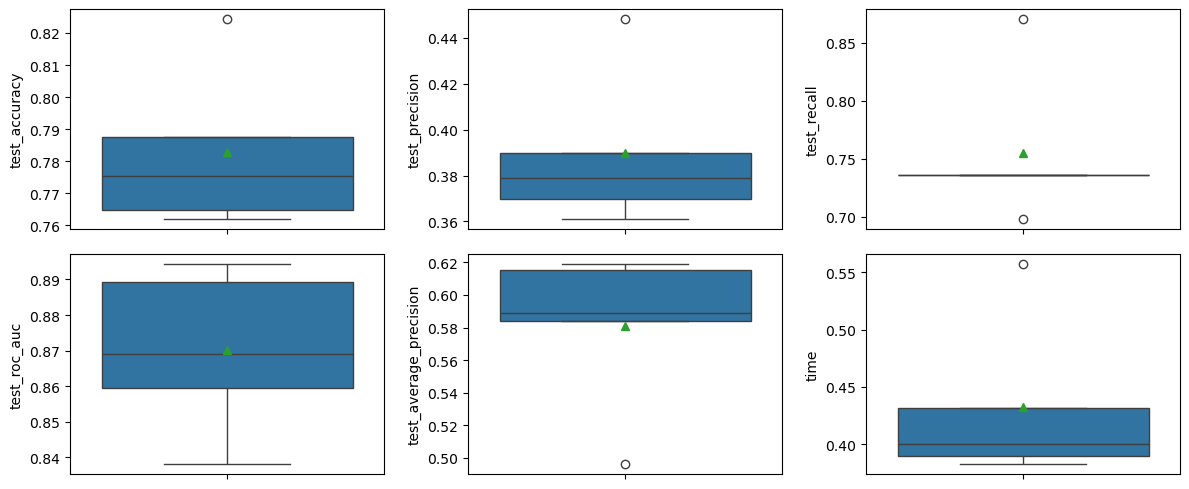

In [24]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(12, 5), tight_layout=True)
cols = dfi_scores_best.columns[2:].to_list()
for ax, col in zip(axs.flatten(), cols):
    sns.boxplot(y=col, data=dfi_scores_best, ax=ax, showmeans=True)
plt.show()

- After hyperparameter optimization, the Logistic Regression model shows significant improvements in recall, ROC AUC, and average precision, enhancing the model's effectiveness in identifying true positives and distinguishing between classes, without adding substantial training time.

### Feature Importance and Final Evaluation

In [25]:
# Refit model on the entire dataset for feature importance
pipeline_logreg_best.fit(X, y)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('onehot', OneHotEncoder(),
                                                  ['Education',
                                                   'Marital_Status', 'AgeGroup',
                                                   'ChildrenPresence',
                                                   'AcceptedSomeCmp',
                                                   'AcceptedCmp1',
                                                   'AcceptedCmp2',
                                                   'AcceptedCmp3',
                                                   'AcceptedCmp4',
                                                   'AcceptedCmp5', 'Complain',
                                                   'Kidhome', 'Teenhome',
                                                   'YearsEnrolled',
                                                   'NbChildren',
                                                   'AcceptedCmpTotal',
                                                   'Cluster']),
                                                 ('standardsc',...
                                                   'NumWebPurchases',
                                                   'NumCatalogPurchases',
                                                   'NumStorePurchases',
                                                   'NumWebVisitsMonth',
                                                   'MntTotal', 'MntRegProds',
                                                   'NumTotalPurchases']),
                                                 ('minmaxsc', MinMaxScaler(),
                                                  ['Recency',
                                                   'DaysEnrolled'])])),
                ('feature_selection', SelectKBest(k=25)),
                ('rus', RandomUnderSampler(random_state=42)),
                ('model',
                 LogisticRegression(C=1000.0, penalty='l1', random_state=42,
                                    solver='liblinear'))])

In [26]:
# Retrieve feature importances
importance = pipeline_logreg_best.named_steps["model"].coef_[0]

feature_names_selec = pipeline_logreg_best.named_steps["feature_selection"].get_feature_names_out(pipeline_logreg_best.named_steps["preprocessing"].get_feature_names_out())
dfi_importance = pd.DataFrame({"name": feature_names_selec, "importance": importance})

# Sort by feature importance
dfi_importance = dfi_importance.sort_values(by="importance", ascending=False)
dfi_importance

,name,importance
3,onehot__AcceptedSomeCmp_1,4.784907
24,minmaxsc__DaysEnrolled,3.863951
19,powertrans__MntMeatProducts,1.444467
7,onehot__AcceptedCmp3_1,0.974685
21,powertrans__MntTotal,0.942599
12,onehot__NbChildren_0,0.677029
5,onehot__AcceptedCmp1_1,0.512357
11,onehot__AcceptedCmp5_1,0.411135
20,powertrans__NumCatalogPurchases,0.345975
4,onehot__AcceptedCmp1_0,0.167527


- The feature importance values reveal that campaign acceptance, register duration, and spending habits are key predictors of the target behavior. However, the negative importance of some campaign acceptance features suggests complex dynamics that might require further investigation.

In [27]:
# Generate predictions and evaluate on the test set
y_pred_t = pipeline_logreg_best.predict(X_test)
y_pred_proba = pipeline_logreg_best.predict_proba(X_test)[:, 1]

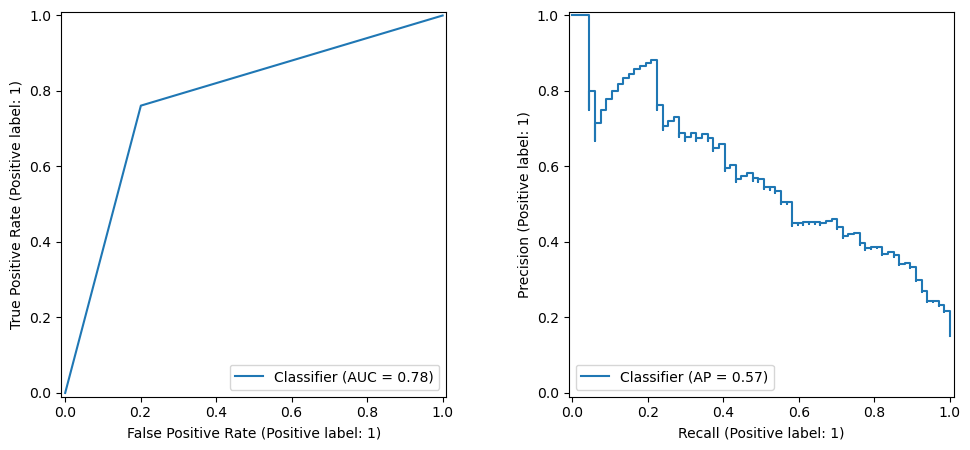

In [28]:
# Plot ROC and Precision-Recall curves for test set
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
RocCurveDisplay.from_predictions(y_test, y_pred_t, ax=axs[0])
PrecisionRecallDisplay.from_predictions(y_test, y_pred_proba, ax=axs[1])
plt.show()

The performance of the Logistic Regression model on the test set improved significantly after hyperparameter optimization:
- AUC increased from 0.69 to 0.78, reflecting a better overall classification capability.
- AP increased from 0.43 to 0.57, indicating an enhanced precision-recall trade-off, with the optimized model maintaining higher precision even as recall increases.

These improvements suggest that the hyperparameter optimization process successfully enhanced the model's performance, making it more effective and reliable in distinguishing between classes and maintaining a good balance between precision and recall.

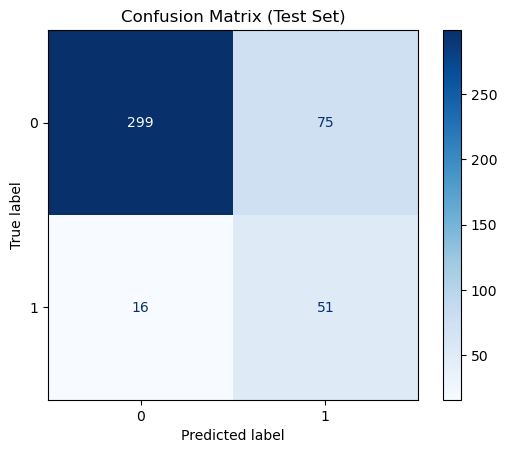

In [29]:
# Create and display confusion matrix for test set
cm_test = confusion_matrix(y_test, y_pred_t)
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=["0", "1"])
disp_test.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix (Test Set)")
plt.show()

- The confusion matrix reveals that the optimized Logistic Regression model has strong recall but lower precision. This indicates that while the model is good at identifying positive cases, it also produces a considerable number of false positives.

In [30]:
# Predict binary outcomes based on a threshold (e.g., 0.5)
y_pred_binary = (y_pred_proba > 0.5).astype(int)

results_bi = pd.DataFrame({
    'Probability': y_pred_proba,
    'Predicted_Response': y_pred_binary,
    'Actual_Response': y_test
})

# Sort the DataFrame by probability to identify individuals more likely to respond positively
sorted_results = results_bi.sort_values(by='Probability', ascending=False)
print("Top Predictions:\n", sorted_results.head(10))
print("Lowest Predictions:\n", sorted_results.tail(10))

Top Predictions:
       Probability  Predicted_Response  Actual_Response
238      0.999929                   1                1
1067     0.999017                   1                1
1684     0.999013                   1                1
400      0.998003                   1                0
1896     0.996207                   1                1
832      0.995555                   1                0
574      0.991893                   1                1
1133     0.983294                   1                1
1889     0.979943                   1                1
71       0.970268                   1                1
Lowest Predictions:
       Probability  Predicted_Response  Actual_Response
1636     0.011860                   0                0
1140     0.011715                   0                0
1856     0.011652                   0                0
1216     0.010682                   0                0
863      0.010336                   0                0
796      0.009584         

- The provided code and results demonstrate how to convert predicted probabilities into binary outcomes and identify the individuals most likely to respond positively. By sorting the predictions by probability, the top predictions can be analyzed for accuracy and model effectiveness. Despite the overall good performance, the presence of false positives suggests that there may still be room for improvement in the model’s precision.